In [1]:
pip install nltk --quiet

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
# ---------------------------
# Load Dataset
# ---------------------------
import pandas as pd

file_path = "test.xlsx"  # Change if needed
df = pd.read_excel(file_path)

print("✅ Data loaded. Shape:", df.shape)
print(df.head())

# ---------------------------
# Clean and Convert to String
# ---------------------------
df['Subject'] = df['Subject'].fillna('').astype(str)
df['body'] = df['body'].fillna('').astype(str)

# ---------------------------
# Task 1: Sentiment Labeling
# ---------------------------


import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"  # Treat empty as neutral
    
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Combine Subject and Body into one text field
df['full_text'] = df['Subject'] + " " + df['body']

# Apply sentiment classification
df['Sentiment'] = df['full_text'].apply(classify_sentiment)

# Preview results
print(df[['Subject', 'Sentiment']].head())

# Save labeled dataset
df.to_csv("labeled_dataset.csv", index=False)
print("✅ Sentiment labeling complete. Saved as 'labeled_dataset.csv'")


✅ Data loaded. Shape: (2191, 4)
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated... 2010-05-10   
1  Marc,\n\nUnfortunately, today is not going to ... 2010-07-29   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ... 2011-07-25   
3  we were thinking papasitos (we can meet somewh... 2010-03-25   
4  Since you never gave me the $20 for the last t... 2011-05-21   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado@enron.com  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\apurv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                        Subject Sentiment
0                          EnronOptions Update!  Positive
1                                  (No Subject)  Positive
2  Phone Screen  Interview - Shannon L. Burnham   Neutral
3                         RE: My new work email   Neutral
4                                           Bet  Positive
✅ Sentiment labeling complete. Saved as 'labeled_dataset.csv'



🔍 Missing values per column:
 Subject      0
body         0
date         0
from         0
full_text    0
Sentiment    0
dtype: int64


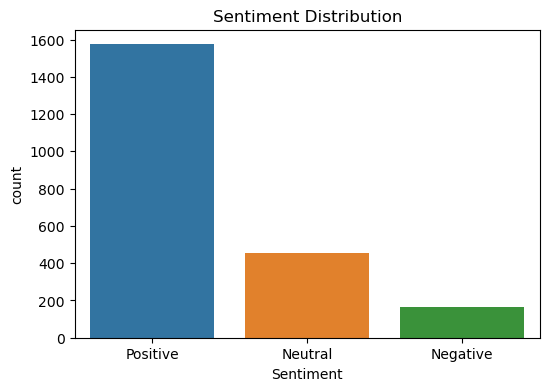

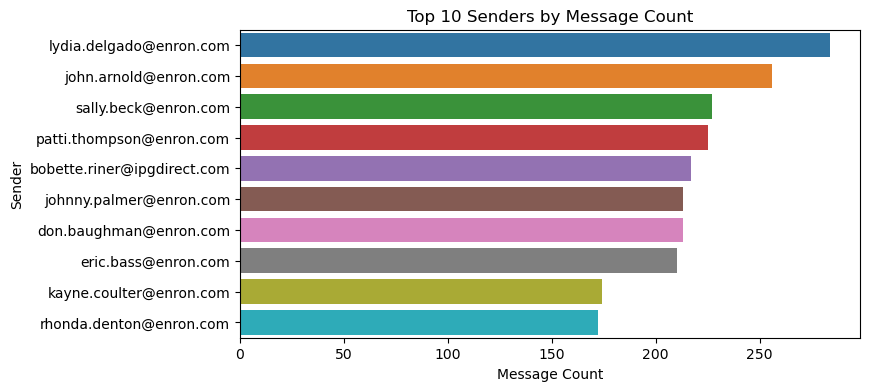

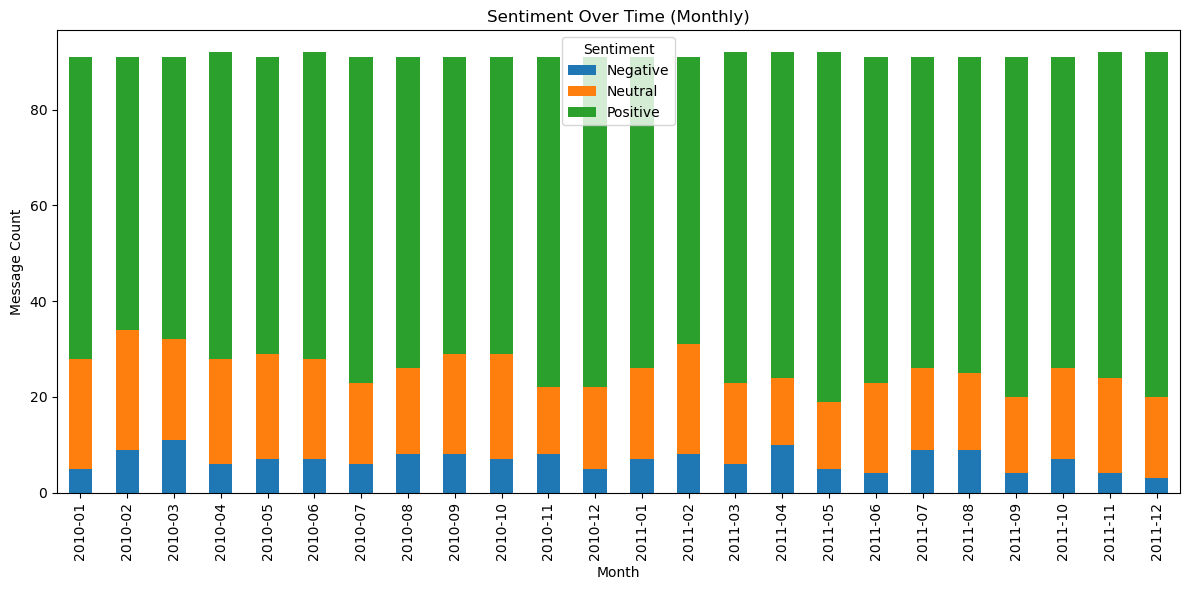

✅ EDA complete. Visualizations saved in 'visualization/' folder.


In [4]:
# ---------------------------
# Task 2: Exploratory Data Analysis (EDA)
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create folder for saving plots
os.makedirs("visualization", exist_ok=True)

# Missing values check
print("\n🔍 Missing values per column:\n", df.isnull().sum())

# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution")
plt.savefig("visualization/sentiment_distribution.png")
plt.show()

# Top 10 senders by message count
top_senders = df['from'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_senders.values, y=top_senders.index)
plt.title("Top 10 Senders by Message Count")
plt.xlabel("Message Count")
plt.ylabel("Sender")
plt.savefig("visualization/top_senders.png")
plt.show()

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Sentiment over time (monthly)
sentiment_over_time = df.groupby(df['date'].dt.to_period("M"))['Sentiment'].value_counts().unstack().fillna(0)

sentiment_over_time.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Sentiment Over Time (Monthly)")
plt.ylabel("Message Count")
plt.xlabel("Month")
plt.tight_layout()
plt.savefig("visualization/sentiment_over_time.png")
plt.show()

print("✅ EDA complete. Visualizations saved in 'visualization/' folder.")


In [5]:
# ---------------------------
# Task 3: Monthly Sentiment Scoring
# ---------------------------

# Map sentiment to numeric scores
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_map)

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract year-month for grouping
df['YearMonth'] = df['date'].dt.to_period('M')

# Group by employee and month to calculate monthly score
monthly_scores = (
    df.groupby(['from', 'YearMonth'])['Sentiment_Score']
    .sum()
    .reset_index()
    .sort_values(['YearMonth', 'Sentiment_Score'], ascending=[True, False])
)

# Save monthly scores
monthly_scores.to_csv("monthly_sentiment_scores.csv", index=False)

print("✅ Monthly sentiment scoring complete. Saved as 'monthly_sentiment_scores.csv'")
print(monthly_scores.head(10))


✅ Monthly sentiment scoring complete. Saved as 'monthly_sentiment_scores.csv'
                            from YearMonth  Sentiment_Score
120      kayne.coulter@enron.com   2010-01               14
48           eric.bass@enron.com   2010-01                9
144      lydia.delgado@enron.com   2010-01                9
24        don.baughman@enron.com   2010-01                8
168     patti.thompson@enron.com   2010-01                6
72         john.arnold@enron.com   2010-01                5
96       johnny.palmer@enron.com   2010-01                3
216         sally.beck@enron.com   2010-01                2
0    bobette.riner@ipgdirect.com   2010-01                1
192      rhonda.denton@enron.com   2010-01                1


In [6]:
# ---------------------------
# Task 4: Employee Ranking
# ---------------------------

#working with the monthly_scores from Task 3
monthly_scores = pd.read_csv("monthly_sentiment_scores.csv")
monthly_scores['YearMonth'] = pd.PeriodIndex(monthly_scores['YearMonth'], freq='M')

# Top 3 Positive per month
top_positive = (
    monthly_scores
    .sort_values(['YearMonth', 'Sentiment_Score', 'from'], ascending=[True, False, True])
    .groupby('YearMonth')
    .head(3)
)

# Top 3 Negative per month
top_negative = (
    monthly_scores
    .sort_values(['YearMonth', 'Sentiment_Score', 'from'], ascending=[True, True, True])
    .groupby('YearMonth')
    .head(3)
)

# Save results
top_positive.to_csv("top3_positive_per_month.csv", index=False)
top_negative.to_csv("top3_negative_per_month.csv", index=False)

print("✅ Ranking complete.")
print("\n📌 Top Positive Employees (sample):")
print(top_positive.head(10))
print("\n📌 Top Negative Employees (sample):")
print(top_negative.head(10))


✅ Ranking complete.

📌 Top Positive Employees (sample):
                           from YearMonth  Sentiment_Score
0       kayne.coulter@enron.com   2010-01               14
1           eric.bass@enron.com   2010-01                9
2       lydia.delgado@enron.com   2010-01                9
10        john.arnold@enron.com   2010-02               12
11      johnny.palmer@enron.com   2010-02               10
12  bobette.riner@ipgdirect.com   2010-02                8
20         sally.beck@enron.com   2010-03               11
21        john.arnold@enron.com   2010-03                7
22          eric.bass@enron.com   2010-03                6
30       don.baughman@enron.com   2010-04                9

📌 Top Negative Employees (sample):
                           from YearMonth  Sentiment_Score
8   bobette.riner@ipgdirect.com   2010-01                1
9       rhonda.denton@enron.com   2010-01                1
7          sally.beck@enron.com   2010-01                2
17      kayne.coulter@e

In [7]:
# Task 5: Flight Risk Identification

# date is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter only negative messages
negative_df = df[df['Sentiment'] == 'Negative'].copy()

# Sort by employee and date
negative_df = negative_df.sort_values(['from', 'date'])

# Function to check rolling 30-day negative count
from collections import defaultdict

flight_risk_employees = set()

for employee, group in negative_df.groupby('from'):
    dates = group['date'].sort_values().tolist()
    for i in range(len(dates)):
        # Count messages in the 30-day window starting from dates[i]
        count_in_window = sum((d - dates[i]).days <= 30 for d in dates[i:])
        if count_in_window >= 4:
            flight_risk_employees.add(employee)
            break  # No need to check further for this employee

# Save to CSV
flight_risk_df = pd.DataFrame({'Employee': list(flight_risk_employees)})
flight_risk_df.to_csv("flight_risk_employees.csv", index=False)

print("✅ Flight risk detection complete. Saved as 'flight_risk_employees.csv'")
print("🚨 Flight Risk Employees Found:", len(flight_risk_employees))
print(flight_risk_df)



✅ Flight risk detection complete. Saved as 'flight_risk_employees.csv'
🚨 Flight Risk Employees Found: 5
                      Employee
0          eric.bass@enron.com
1      johnny.palmer@enron.com
2         sally.beck@enron.com
3  bobette.riner@ipgdirect.com
4     patti.thompson@enron.com


In [8]:
# Task 6: Predictive Modeling


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Feature Engineering
df['message_length'] = df['full_text'].apply(len)
df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))

# Monthly message frequency per employee
monthly_message_count = (
    df.groupby(['from', df['date'].dt.to_period('M')])['full_text']
    .count()
    .reset_index(name='monthly_message_count')
)

# Merge monthly sentiment scores from Task 3
monthly_scores = pd.read_csv("monthly_sentiment_scores.csv")
monthly_scores['YearMonth'] = pd.PeriodIndex(monthly_scores['YearMonth'], freq='M')

# Merge features into monthly_scores
monthly_features = monthly_scores.merge(
    monthly_message_count,
    left_on=['from', 'YearMonth'],
    right_on=['from', 'date'],
    how='left'
)

# Merge average message length and word count per month
monthly_avg_features = (
    df.groupby(['from', df['date'].dt.to_period('M')])
    .agg(avg_length=('message_length', 'mean'),
         avg_word_count=('word_count', 'mean'))
    .reset_index()
)

monthly_features = monthly_features.merge(
    monthly_avg_features,
    left_on=['from', 'YearMonth'],
    right_on=['from', 'date'],
    how='left'
)

# Drop extra date columns
monthly_features = monthly_features.drop(columns=['date_x', 'date_y'])

# Fill NaN with 0
monthly_features = monthly_features.fillna(0)

# Define X and y
X = monthly_features[['monthly_message_count', 'avg_length', 'avg_word_count']]
y = monthly_features['Sentiment_Score']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Predictive Modeling Complete")
print("📊 RMSE:", rmse)
print("📊 R² Score:", r2)

# Save model coefficients
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coeff_df.to_csv("model_coefficients.csv", index=False)

print("\nModel Coefficients:")
print(coeff_df)


✅ Predictive Modeling Complete
📊 RMSE: 1.4391271936125085
📊 R² Score: 0.8003437392917944

Model Coefficients:
                 Feature  Coefficient
0  monthly_message_count     0.640256
1             avg_length    -0.001150
2         avg_word_count     0.014177
